### code adapted from http://neuralnetworksanddeeplearning.com/chap1.html

Output at bottom. This method is slow and doesnt get us very far.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pnd

import numpy as np
import random

In [3]:
"""load data"""
with open('dataraw/training.csv','rb') as f_in:
    train = pnd.read_csv(f_in)
with open('dataraw/test.csv','rb') as f_in:
    test = pnd.read_csv(f_in)

In [4]:
"""set aside dev data"""
test_data = test
train_labels, train_data = train.iloc[:,:30], train.iloc[:,30:]

dev_data, dev_labels = train_data[5000:], train_labels.iloc[5000:]
train_data, train_labels = train_data[:5000], train_labels[:5000]
print train_labels.shape, train_data.shape

(5000, 30) (5000, 1)


In [5]:
"""Face Feature Id Columns"""
face = {
'left_eye':(0,1),
'right_eye' : (2,3),
'nose' : (20,21),
'bottom_lib' : (28,29)
    }

In [6]:
def xy_to_index(x_coord, y_coord, rows=96, cols=96):
    """ assumes 0 index on both x and y axes """
    x_coord, y_coord = int(x_coord), int(y_coord)
    index = x_coord + cols * y_coord
    if x_coord >= cols or y_coord >= rows:
        raise Exception('Index not within image limits', index)
    return int(index)

def index_to_xy(index, rows=96, cols=96):
    y,x = divmod(index, cols)
    return (x,y)

In [7]:
def convert_images_to_arrays(image_data):
    out = []
    for d in image_data:
        out.append(np.row_stack( np.array([int(i) for i in d.split()])) )
    return np.array(out)

def convert_labels_to_vectors(label_data, label_index):
    out = []
    for i in xrange(len(label_data)):
        tmp = np.zeros(9216)
        lab_x, lab_y = label_data.iloc[i, label_index[0]], label_data.iloc[i, label_index[1]]
        answer = xy_to_index(lab_x, lab_y, 96, 96)
        tmp[answer] = 1
        out.append(np.row_stack(tmp))
    return np.array(out)

23.4376661777


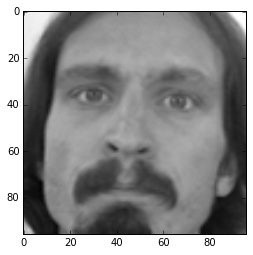

In [8]:
# CONVERT TRAINING DATA
import time

# start = time.time()
# nose_train_labels = convert_labels_to_vectors(train_labels, face['nose'])
# print 'train labels done', time.time() - start
# start = time.time()
# nose_dev_labels = convert_labels_to_vectors(dev_labels, face['nose'])
# print 'dev labels done', time.time() - start
# start = time.time()
# train_images = convert_images_to_arrays(train_data['Image'])
# print 'train images done', time.time() - start
# start = time.time()
# dev_images = convert_images_to_arrays(dev_data['Image'])
# print 'dev images done', time.time() - start


import pickle
# with open('faces.pkl', 'wb') as pk:
#     pickle.dump((train_images, dev_images, nose_train_labels, nose_dev_labels), pk)

start = time.time()
with open('faces.pkl','rb') as pk:
    train_images, dev_images, nose_train_labels, nose_dev_labels = pickle.load(pk)
print time.time() - start

plt.imshow(train_images[0].reshape(96,96), cmap='gray')

In [15]:
# normalize data
n_train_images = [ i / 255.0 for i in train_images]
n_dev_images = [ i / 255.0 for i in dev_images]
print 'done'

done


In [18]:
print n_train_images[0][np.argmax(n_train_images[0])]
print n_dev_images[0][np.argmax(n_dev_images[0])]


[ 0.99215686]
[ 0.98431373]


###Simple Neural Network

In [8]:
class Network(object):
    def __init__(self, sizes):
        self.sizes = sizes
        self.num_layers = len(sizes)
        self.biases = [np.random.randn(y,1) for y in sizes[1:]]
        self.weights = [np.random.randn(y,x) for y,x in zip(sizes[1:], sizes[:-1])]

In [9]:
def sigmoid(z):
    return float(1)/(float(1) + np.exp(-z))

In [46]:
class FFNetwork(Network):
    def __init__(self, sizes):
        super(FFNetwork, self).__init__(sizes)
        
    def feedforward(self, a):
        for w,b in zip(self.weights, self.biases):
            a = sigmoid(np.dot(w,a) + b)
        return a
    
    def SGD(self, training_data, epochs, batch_size, eta, test_data=None):
        if test_data: n_test = len(test_data)
        
        n = len(training_data)
        for i in xrange(epochs):
            start = time.time()
            print 'Starting Epoch', i
            random.shuffle(training_data)
            batches = [training_data[k:k+batch_size] for k in xrange(0,n,batch_size)]
            for batch in batches:
                self.update_batch(batch, eta)
            print time.time() - start
            if test_data:
                print "Epoch {0}: {1}".format(
                    i, self.evaluate(test_data))
            else:
                print "Epoch {0} complete".format(i)
                
    def update_batch(self, batch, eta):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        for x,y in batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x,y)
            nabla_b = [nb + dnb for nb,dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw,dnw in zip(nabla_w, delta_nabla_w)]            
        self.weights = [w - (eta/len(batch)) * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (eta/len(batch)) * bw for b, bw in zip(self.biases, nabla_b)]
        
        
    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
#             print w.shape, activation.shape, b.shape,'|',
            z = np.dot(w, activation)+b
#             print z.shape,
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
#             print activation.shape
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(index_to_xy(np.argmax(self.feedforward(x))), index_to_xy(np.argmax(y)))
                        for (x, y) in test_data]
        test_distances = [ np.sqrt((p[0]-a[0])**2 + (p[1]-a[1])**2) for (p,a) in test_results  ]
        print test_results
#         print test_distances
#         print np.mean(test_distances)
#         raise Exception
        return np.mean(test_distances)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

In [25]:

#### Libraries
# Standard library
import cPickle
import gzip

# Third-party libraries
import numpy as np

def load_data():
#     f = gzip.open('data/mnist.pkl.gz', 'rb')
    with open('mnist.pkl','rb') as pk:
        training_data, validation_data, test_data = cPickle.load(pk)
    return (training_data, validation_data, test_data)

def load_data_wrapper():

    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):

    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [26]:
# load mnist data
# training_data, validation_data, test_data = load_data_wrapper()
# print training_data[0][0]
# print train_images[0].shape
# print np.row_stack(train_images[0]).shape

In [30]:
class CrossEntropyCost(object):

    @staticmethod
    def fn(a, y):
        """Return the cost associated with an output ``a`` and desired output
        ``y``.  Note that np.nan_to_num is used to ensure numerical
        stability.  In particular, if both ``a`` and ``y`` have a 1.0
        in the same slot, then the expression (1-y)*np.log(1-a)
        returns nan.  The np.nan_to_num ensures that that is converted
        to the correct value (0.0).

        """
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

    @staticmethod
    def delta(z, a, y):
        """Return the error delta from the output layer.  Note that the
        parameter ``z`` is not used by the method.  It is included in
        the method's parameters in order to make the interface
        consistent with the delta method for other cost classes.

        """
        return (a-y)

In [35]:
#### Libraries
# Standard library
import random

# Third-party libraries
import numpy as np

class Network(object):

    def __init__(self, sizes, cost=CrossEntropyCost):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        self.cost = cost

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, lmbda = 0.0,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in xrange(epochs):
            print 'Starting Epoch', j
            start = time.time()
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in xrange(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lmbda, len(mini_batch))
            print time.time() - start, 'seconds to complete'
            if test_data:
                print "Epoch {0}: {1} ".format(
                    j, self.evaluate(test_data))
            else:
                print "Epoch {0} complete".format(j)

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in xrange(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
#     def evaluate(self, test_data):
#         """Return the number of test inputs for which the neural
#         network outputs the correct result. Note that the neural
#         network's output is assumed to be the index of whichever
#         neuron in the final layer has the highest activation."""
#         test_results = [(np.argmax(self.feedforward(x)), y)
#                         for (x, y) in test_data]
#         return sum(int(x == y) for (x, y) in test_results)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(index_to_xy(np.argmax(self.feedforward(x))), index_to_xy(np.argmax(y)))
                        for (x, y) in test_data]
        test_distances = [ np.sqrt((p[0]-a[0])**2 + (p[1]-a[1])**2) for (p,a) in test_results  ]
        print test_results
#         print test_distances
#         print np.mean(test_distances)
#         raise Exception
        return np.mean(test_distances)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))

####LOAD FACE DATA
    We're going to try to find noses first

In [50]:
# # render one dev face
# ix = 0

# print dev_labels.iloc[ix,20:22]
# # face_list = [int(i) for i in dev_data['Image'].iloc[ix].split()]
# face = np.array(face_list).reshape(96,96)
# face = dev_images[ix]
# plt.imshow(face, cmap='gray')
# # plt.plot(dev_labels.iloc[ix,20], dev_labels.iloc[ix,21], 'bo')
# plt.show()



In [ ]:
print 'Start'
net = Network([9216,5000,9216])
print net.sizes
print 'Go'

net.SGD(zip(n_train_images, nose_train_labels), 30, 5, .25, 0.0, \
        zip(n_train_images[:10] + n_dev_images[:30], \
            (list(nose_train_labels[:10]) + list(nose_dev_labels[:30]))) )

# net = Network([784,100,100,100,100,10])
# net.SGD(training_data, 30, 25, 3.0, test_data)
# # net.SGD(training_data, 30, 25, 3.0)
# net.evaluate(test_data)

Start
[9216, 5000, 9216]

In [25]:
# 8644 / 10000

In [26]:
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.

SyntaxError: invalid syntax (<ipython-input-26-d4e763b4db2a>, line 1)